# HW05: Word Embeddings

Remember that these homework work as a completion grade. **You can <span style="color:red">not</span> skip one section this homework.**

**Essay Feedback**

Please provide feedback to two classmates' essays on Eduflow.

**Training word2vec**

In this section, we train a word2vec model using gensim. We train the model on text8 (which consists of the first 90M characters of a Wikipedia dump from 2006 and is considered one of the benchmarks for evaluating language models).

In [ ]:
import gensim.downloader as api

api.info("text8")

{'num_records': 1701,
 'record_format': 'list of str (tokens)',
 'file_size': 33182058,
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/text8/__init__.py',
 'license': 'not found',
 'description': 'First 100,000,000 bytes of plain text from Wikipedia. Used for testing purposes; see wiki-english-* for proper full Wikipedia datasets.',
 'checksum': '68799af40b6bda07dfa47a32612e5364',
 'file_name': 'text8.gz',
 'read_more': ['http://mattmahoney.net/dc/textdata.html'],
 'parts': 1}

In [ ]:
dataset = api.load("text8")

In [ ]:
from gensim.models import Word2Vec

##TODO train a word2vec model on this dataset
model = Word2Vec(dataset)

**Word Similarities**

gensim models provide almost all the utility you might want to wish for to perform standard word similarity tasks. They are available in the .wv (wordvectors) attribute of the model, more details could be found [here](https://radimrehurek.com/gensim/models/keyedvectors.html).

In [ ]:
model.wv

##TODO find the closest words to king
model.wv.most_similar("king")

[('prince', 0.726273775100708),
 ('queen', 0.6980648040771484),
 ('kings', 0.6886549592018127),
 ('emperor', 0.6865004301071167),
 ('throne', 0.681995153427124),
 ('pharaoh', 0.6693165302276611),
 ('pope', 0.6563782691955566),
 ('constantine', 0.6516705751419067),
 ('vii', 0.6498949527740479),
 ('regent', 0.6464978456497192)]

King is to man as woman is to X

In [ ]:
##TODO find the closest word for the vector "woman" + "king" - "man"
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6654013991355896),
 ('empress', 0.6243665814399719),
 ('throne', 0.610744833946228),
 ('son', 0.6063821315765381),
 ('princess', 0.6050381660461426),
 ('elizabeth', 0.6013904213905334),
 ('isabella', 0.5984888076782227),
 ('emperor', 0.5977045893669128),
 ('prince', 0.5955239534378052),
 ('daughter', 0.5800724625587463)]

**Evaluate Word Similarities** 

One common way to evaluate word2vec models are word analogy tasks. Let's check how good our model is on one of those. We consider the [WordSim353](http://alfonseca.org/eng/research/wordsim353.html) benchmark, the task is to determine how similar two words are.

In [ ]:
!wget http://alfonseca.org/pubs/ws353simrel.tar.gz
!tar xf ws353simrel.tar.gz

path = "wordsim353_sim_rel/wordsim_similarity_goldstandard.txt"

def load_data(path):
    X, y = [], []
    with open(path) as f:
        for line in f:
            line = line.strip().split("\t")
            X.append((line[0], line[1])) # each entry in x contains two words, e.g. X[0] = (tiger, cat)
            y.append(float(line[-1])) # each entry in y is the annotation how similar two words are, e.g. Y[0] = 7.35
    return X, y

X, y = load_data(path)
print (X[:3], y[:3])

--2023-03-22 15:22:36--  http://alfonseca.org/pubs/ws353simrel.tar.gz
Resolving alfonseca.org (alfonseca.org)... 162.215.249.67
Connecting to alfonseca.org (alfonseca.org)|162.215.249.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5460 (5.3K) [application/x-gzip]
Saving to: ‘ws353simrel.tar.gz’

ws353simrel.tar.gz  100%[===================>]   5.33K  --.-KB/s    in 0s      

2023-03-22 15:22:36 (121 MB/s) - ‘ws353simrel.tar.gz’ saved [5460/5460]

[('tiger', 'cat'), ('tiger', 'tiger'), ('plane', 'car')] [7.35, 10.0, 5.77]


In [ ]:
##TODO compute how similar the pairs in the WordSim353 are according to our model
# if a word is not present in our model, we assign similarity 0 for the respective text pair
import pandas as pd
import numpy as np

sim_w2v=[]

for pair in X:
    if pair[0] in model.wv.vocab.keys() and pair[1] in model.wv.vocab.keys():
        sim_w2v.append(model.wv.similarity(pair[0], pair[1]))
    else:
        sim_w2v.append(0)
        
sim = pd.DataFrame(list(zip(X, y, sim_w2v)), columns=['pairs', 'similarities_wordsim', 'similarities_w2v'])
sim.head() 

,pairs,similarities_wordsim,similarities_w2v
0,"(tiger, cat)",7.35,0.591854
1,"(tiger, tiger)",10.00,1.000000
2,"(plane, car)",5.77,0.435306
3,"(train, car)",6.31,0.547997
4,"(television, radio)",6.77,0.742991


In [ ]:
from scipy.stats import spearmanr

##TODO compute spearman's rank correlation between our prediction and the human annotations
spearmanr(y, sim_w2v)

SignificanceResult(statistic=0.6351688386690448, pvalue=2.4950789051056e-24)

In [ ]:
import spacy
en = spacy.load('en_core_web_sm')

##TODO compute word similarities in the WordSim353 dataset using spaCy word embeddings
sim_spacy=[]

for pair in X:
    sim_spacy.append(en(pair[0]).similarity(en(pair[1])))

sim['similarities_spacy']=sim_spacy
##TODO compute spearman's rank correlation between these similarities and the human annotations
# Don't worry if results are not too convincing for this experiment
spearmanr(y, sim_spacy)

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
<ipython-input-12-6db0a90d9fec>:8: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  sim_spacy.append(en(pair[0]).similarity(en(pair[1])))


SignificanceResult(statistic=0.0917488312498204, pvalue=0.19295227692420674)

**PyTorch Embeddings**

In [1]:
#Import the AG news dataset (same as hw01)
#Download them from here 
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df = df.sample(n=10000) # # only use 10K datapoints
df.head()

--2023-03-27 19:08:25--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M  --.-KB/s    in 0.1s    

2023-03-27 19:08:26 (189 MB/s) - ‘train.csv’ saved [29470338/29470338]



,label,title,lead,text
86247,sci/tech,"IBM Plans Web Meeting Service, Takes Aim at We...",Reuters - IBM plans to offer\Web-conferencing...,"IBM Plans Web Meeting Service, Takes Aim at We..."
75671,sport,Langer goes after tea,Opener Justin Langer has been dismissed after ...,Langer goes after tea Opener Justin Langer has...
75706,business,Verizon Posts Flat Third-Quarter Earnings (Reu...,"Reuters - Verizon Communications Inc. ,\the la...",Verizon Posts Flat Third-Quarter Earnings (Reu...
46287,business,Qualcomm opens CDMA development centre in Hyde...,Code Division Multiple Access (CDMA) technolog...,Qualcomm opens CDMA development centre in Hyde...
73054,business,Local managers happy to see Murdoch #39;s back,Australian shareholders had two significant ex...,Local managers happy to see Murdoch #39;s back...


In [3]:
from gensim.utils import tokenize
from collections import Counter
vocab = 200
##TODO tokenize the text, only keep 200 most frequent words 
tokenized_text = [list(tokenize(t, lowercase=True)) for t in df['text']]
whole_corpus = []
for t in tokenized_text:
  whole_corpus.extend(t)
common_words = set([t[0] for t in Counter(whole_corpus).most_common(vocab)])
word2id = {w : i + 1 for i, w in enumerate(common_words)}
filtered_sents = [[word2id[w] for w in t if w in common_words] for t in tokenized_text]

In [6]:
length = 100
import numpy as np
#TODO create a one_hot representation for each word and truncate/pad the sequences such that they are all of the same length (here we use 100)
X = np.array([(100 - len(s)) * [0] + s if len(s) < 100 else s[:100] for s in filtered_sents])
X.shape

(10000, 100)

(10000,)


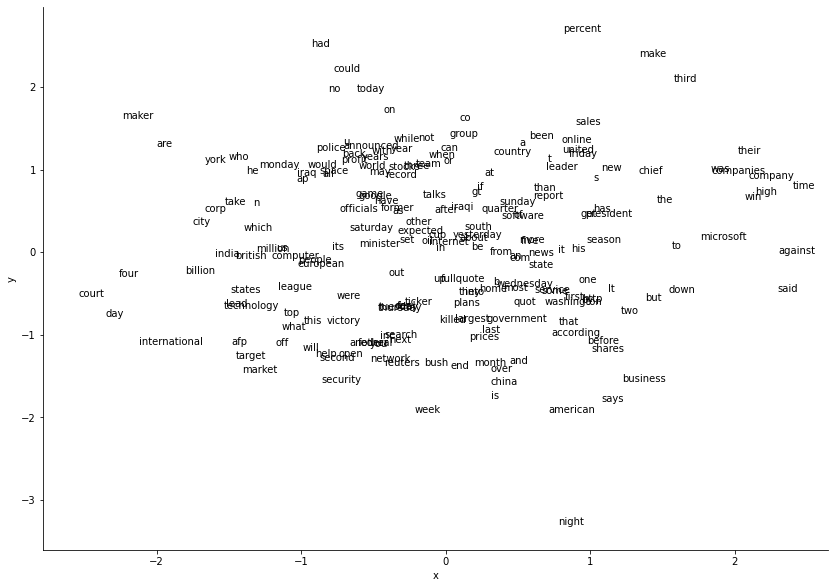

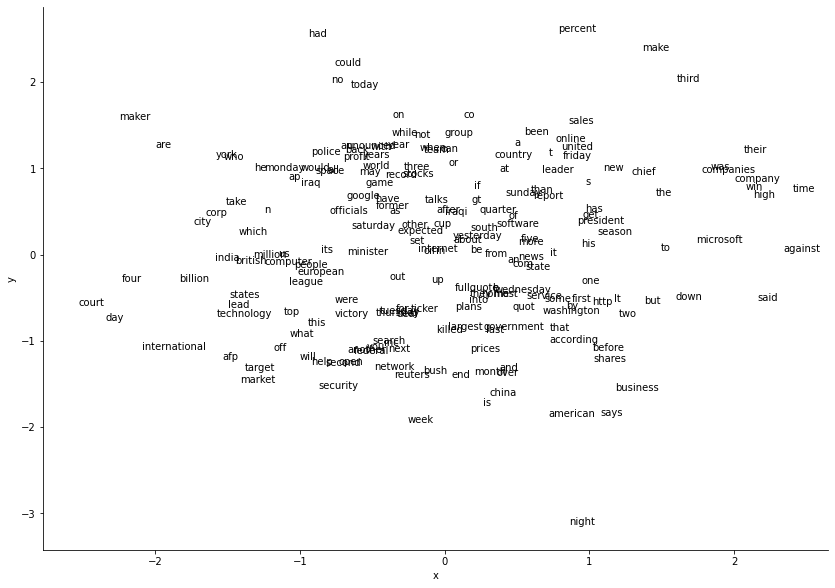

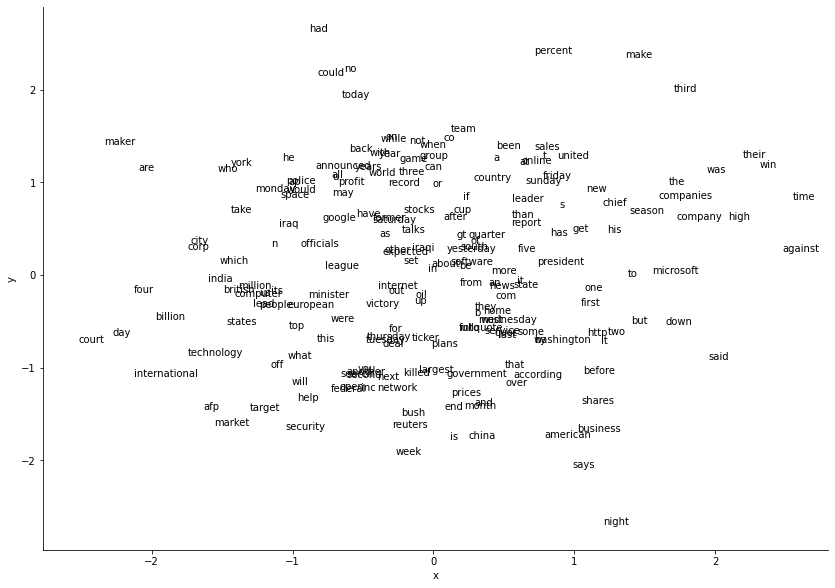

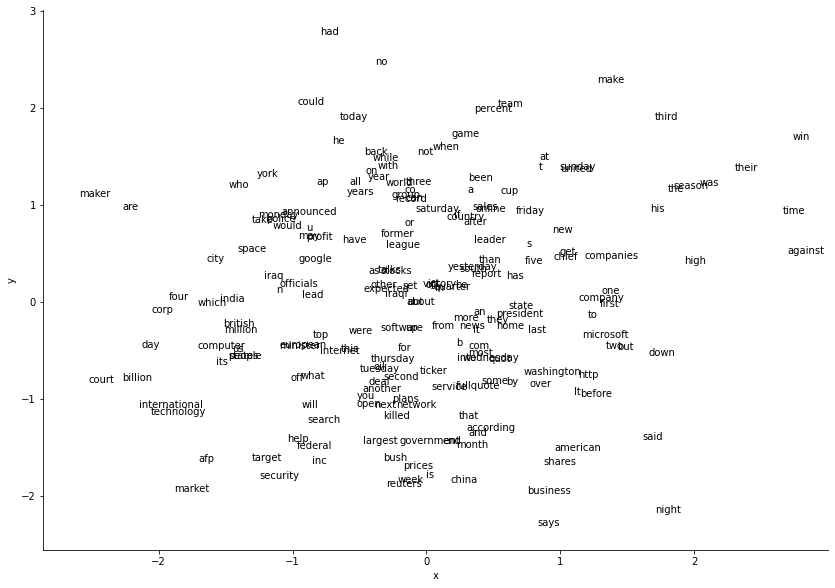

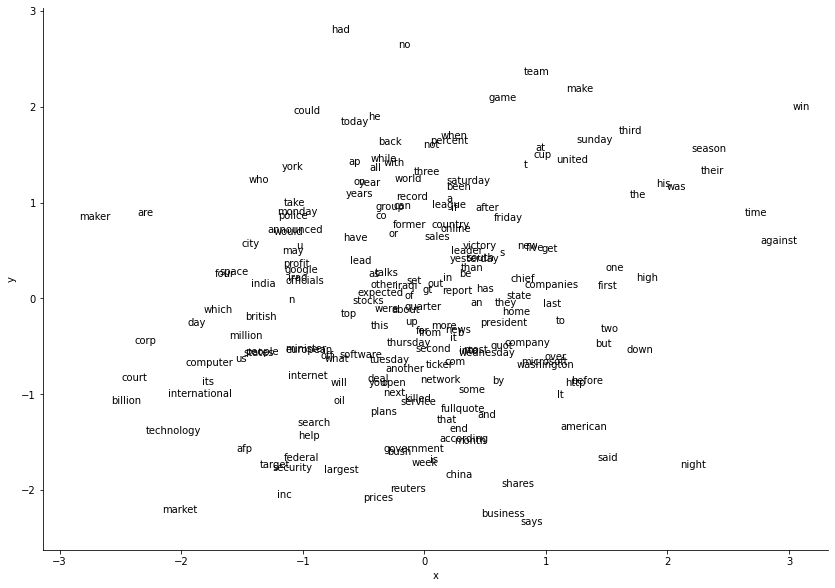

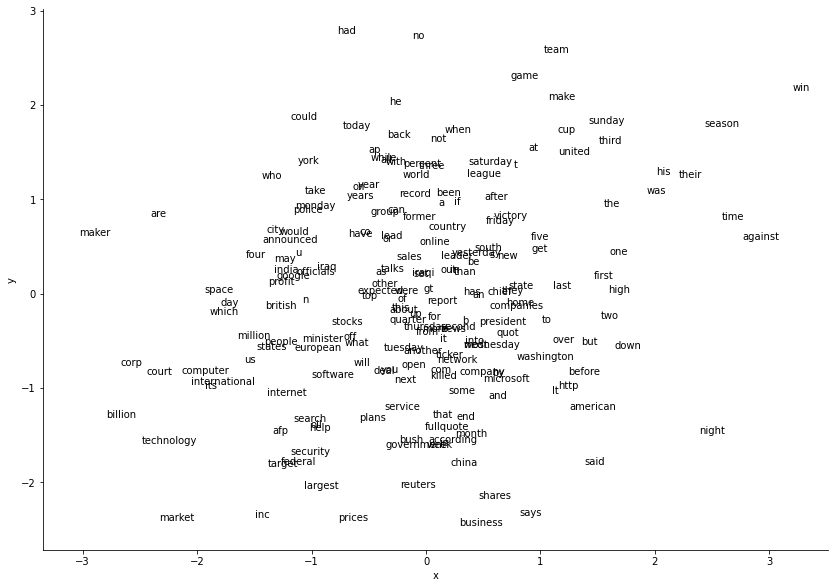

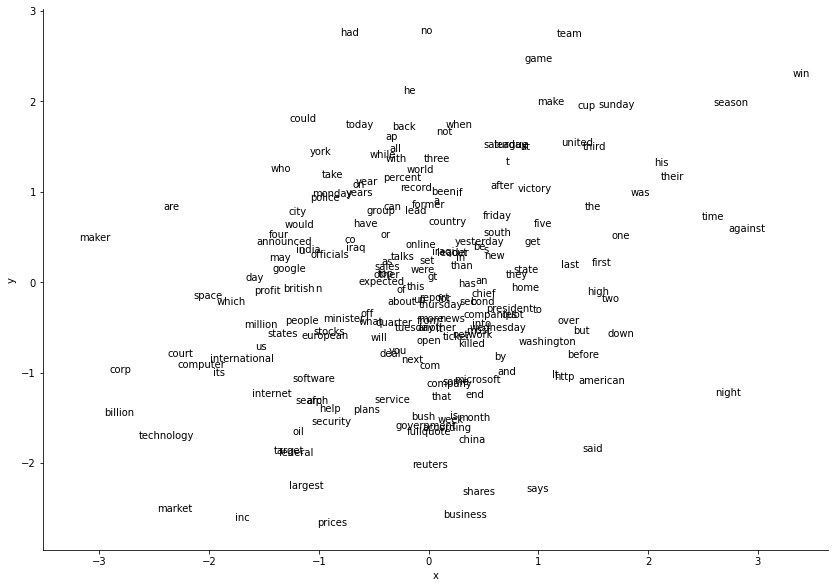

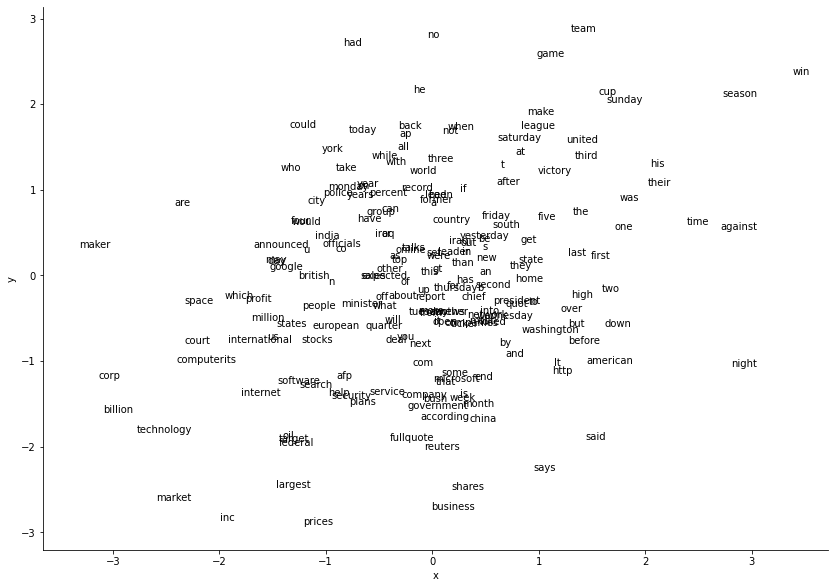

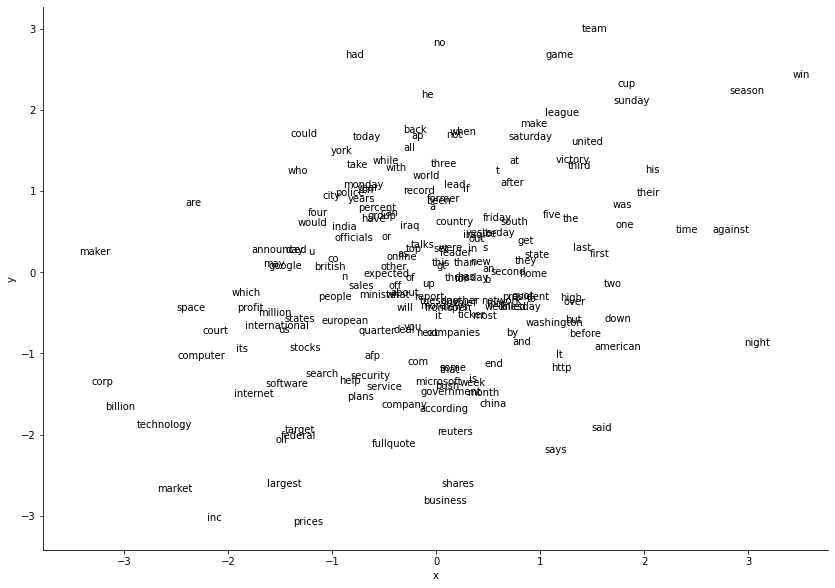

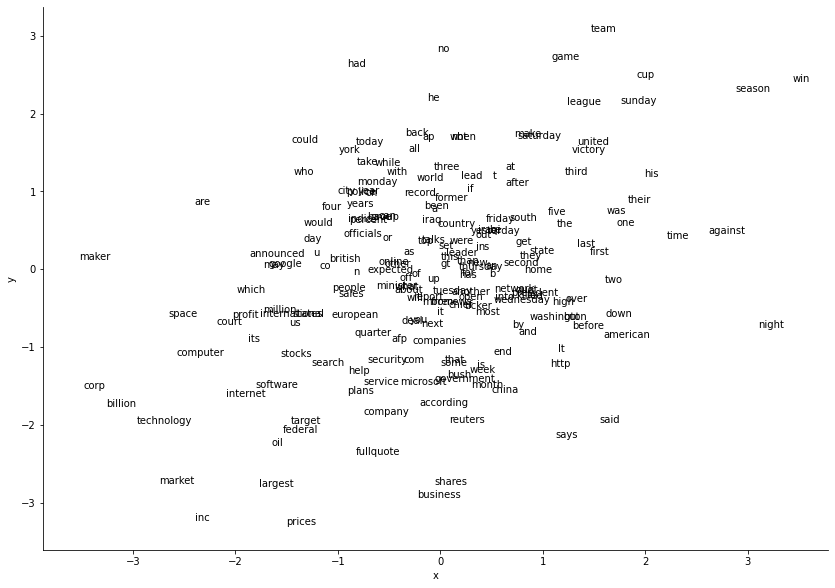

In [15]:
##TODO create your torch embedding like we did in notebook 5! (hint: predicting labels: world, sport, business, and sci/tech)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

label2id = {"world": 0, "sport": 1, "business": 2, "sci/tech": 3}
y = df["label"].apply(lambda x: label2id[x]).values
print(y.shape)

df3 = pd.DataFrame(list(word2id.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:vocab]


class GenericDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

class EmbeddingNet(nn.Module):
  def __init__(self, num_words=200):
    super(EmbeddingNet, self).__init__()
    self.embedding = nn.Embedding(num_words + 1, 2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(2 * 100, 4)
    self.fc2 = nn.Linear(4, 4)

  def forward(self, x):
    x = self.embedding(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

model = EmbeddingNet(num_words=vocab)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

dataset = GenericDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

for i in range(10):
  if i > 0:
    for data, label in loader:
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs, label)
      loss.backward()
      optimizer.step()
  for name, param in model.named_parameters():
    if 'embedding' in name:
      word_vectors = param.data
  df3['x'] = word_vectors[1:,0]
  df3['y'] = word_vectors[1:,1]


  plot = sns.relplot( data=df3, x="x", y="y", s=0, height=8.27, aspect=11.7/8.27)

  for row in df3.itertuples():
      ax = plot.axes[0, 0]
      ax.text(row.x, row.y, row.word, horizontalalignment='left')
  plt.show()